In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from src.iaf.experiments import get_experiment

base_dp_ratio = 1.1
apical_dp_ratio = 1.05
no_apical = False
config = "hofer"
num_simulations = 1
sim, cfg = get_experiment(
    config,
    base_dp_ratio=base_dp_ratio,
    apical_dp_ratio=apical_dp_ratio,
    no_apical=no_apical,
    num_simulations=num_simulations
)

In [2]:
results = sim.run(duration=1000)

100%|██████████| 1000/1000 [02:22<00:00,  7.04it/s]


In [3]:
def make_psth(spike_times, duration, dt):
    psth = np.zeros((duration * int(1/dt)))
    psth[spike_times] = 1
    psth = np.sum(np.reshape(psth, (duration, -1)), axis=1)
    return psth

In [6]:
duration = results["weights"][0]["basal"].shape[0]
dt = cfg.dt

psths = np.stack([make_psth(st, duration, dt) for st in results["spike_times"]], axis=0)
basal_weights = np.stack([w["basal"][-1] for w in results["weights"]], axis=0)
simple_weights = np.stack([w["apical-simple"][-1] for w in results["weights"]], axis=0)
complex_weights = np.stack([w["apical-complex"][-1] for w in results["weights"]], axis=0)

/var/folders/7d/qc682nsj13d_bz11bztzd5hm0000gn/T/ipykernel_35680/2029321658.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()


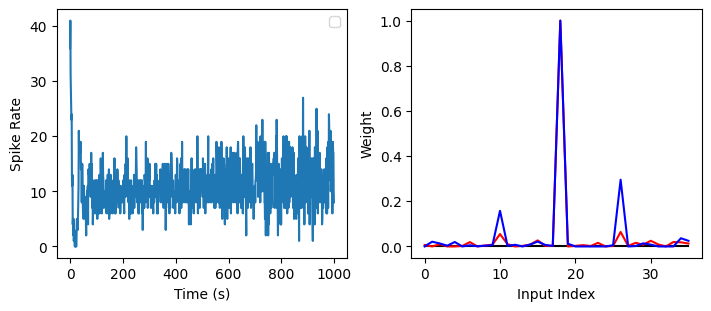

In [9]:
cmap = plt.get_cmap("tab10")
colors = cmap(np.linspace(0, 1, psths.shape[0]))

fig, ax = plt.subplots(1, 2, figsize=(7, 3), layout="constrained")
for ineuron in range(psths.shape[0]):
    ax[0].plot(psths[ineuron], color=colors[ineuron])
    ax[1].plot(basal_weights[ineuron], color="k")
    ax[1].plot(simple_weights[ineuron] / np.max(simple_weights[ineuron]), color="r")
    ax[1].plot(complex_weights[ineuron] / np.max(complex_weights[ineuron]), color="b")
ax[0].legend()
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Spike Rate")
ax[1].set_xlabel("Input Index")
ax[1].set_ylabel("Weight")
plt.show()

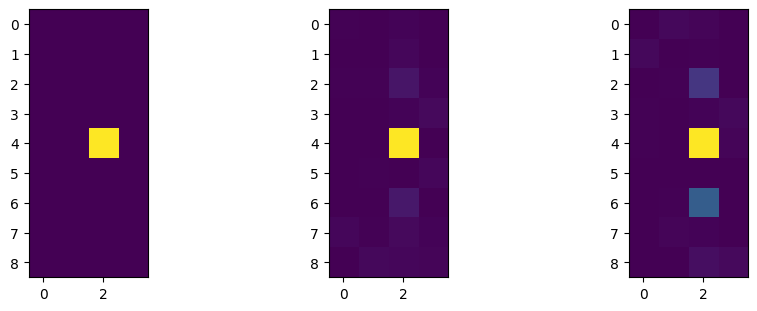

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), layout="constrained")
ax[0].imshow(basal_weights[0].T.reshape(9, 4))
ax[1].imshow(simple_weights[0].T.reshape(9, 4))
ax[2].imshow(complex_weights[0].T.reshape(9, 4))
plt.show()